In [253]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import curve_fit
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Percent voting people

In [254]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Poll data

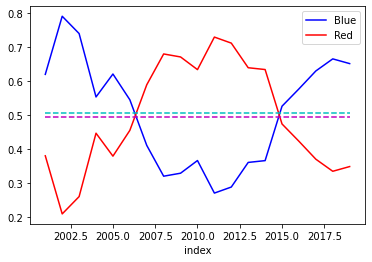

In [255]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [256]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [257]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [258]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [259]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [260]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Stat data

In [261]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [262]:
stat_list_org = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [263]:
stat_list_org[0].columns[stat_list_org[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'wyksztalcenie_wyzsze',
       'udzial_wiek_przedprodukcyjny', 'udzial_wiek_produkcyjny',
       'udzial_wiek_poprodukcyjny', 'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [264]:
data = [['mazowieckie',35558], 
['wielkopolskie',29826], 
['lubelskie',25122], 
['warmińsko-mazurskie',24173], 
['zachodniopomorskie',22892], 
['podlaskie',20187], 
['dolnośląskie',19947], 
['pomorskie',18310], 
['łódzkie',18219], 
['kujawsko-pomorskie',17972], 
['podkarpackie',17846], 
['małopolskie',15183], 
['lubuskie',13988], 
['śląskie',12333], 
['świętokrzyskie',11711], 
['opolskie',9412]]

woj_pow = pd.DataFrame(data, columns=['jednostka','powierzchnnia_km2'])

In [265]:
woj_pow['jednostka'] = woj_pow['jednostka'] .str.upper() 

In [266]:
for s in range(len(stat_list_org)):
    stat_list_org[s] = pd.merge(stat_list_org[s], woj_pow, left_index=True, right_on='jednostka')
    stat_list_org[s] = stat_list_org[s].set_index('jednostka')

## Use 2 approaches to estimate date from years without elections

In [267]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [268]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]

In [269]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

### Correlation
Corr between real data before scaling and outpots for each party based on rescaled output with poll and real data

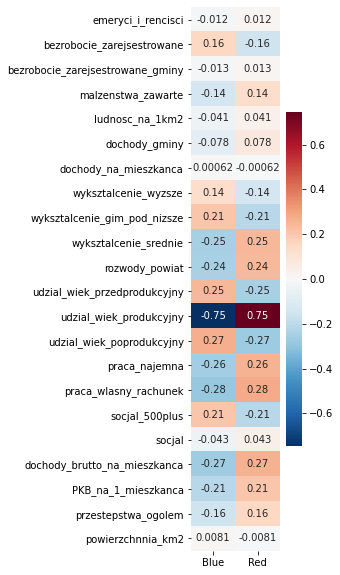

In [270]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

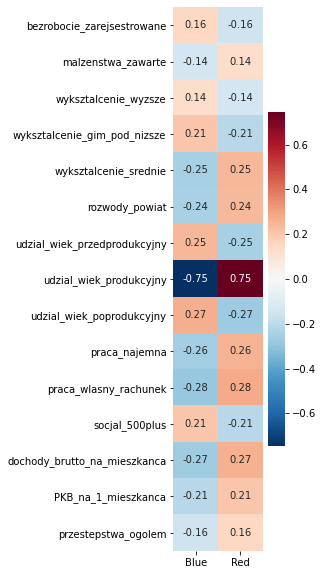

In [271]:
fig, ax = plt.subplots(figsize=(2,10))
pool_names_highcorr = (pool_stat_df_org
                       .corr()
                       .iloc[:-2,-2:][pool_stat_df_org
                                      .corr()
                                      .iloc[:-2,-2:]
                                      .abs() > 0.1]
                       .dropna())
sn.heatmap(pool_names_highcorr.dropna(), annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [272]:
col_highcorr = pool_names_highcorr.index.values.tolist()

In [273]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [274]:
df1_null = stat_list_org[0].count()
col_df1_null = df1_null[df1_null==0].index.values.tolist()

In [275]:
col_df1_null

['bezrobocie_zarejsestrowane_gminy',
 'ludnosc_na_1km2',
 'dochody_na_mieszkanca',
 'udzial_wiek_przedprodukcyjny',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'socjal_500plus',
 'przestepstwa_ogolem']

In [276]:
cols_to_fill = list(set(col_df1_null).intersection(col_highcorr))
cols_to_fill

['udzial_wiek_produkcyjny',
 'przestepstwa_ogolem',
 'udzial_wiek_poprodukcyjny',
 'udzial_wiek_przedprodukcyjny',
 'socjal_500plus']

In [277]:
dflast_null = stat_list_org[-1].count()
col_dflast_null = dflast_null[dflast_null==0].index.values.tolist()
cols_to_fill_last = list(set(col_dflast_null).intersection(col_highcorr))
cols_to_fill_last

['dochody_brutto_na_mieszkanca']

Selecting columns:
- udzial_wiek_produkcyjny 
- udzial_wiek_przedprodukcyjny
- udzial_wiek_poprodukcyjny
- przestepstwa_ogolem
- dochody_brutto_na_mieszkanca (for last)

In [284]:
df_sel_null_col = pd.DataFrame(columns=cols_to_fill+cols_to_fill_last+['ludnosc_na_1km2'])
for s in stat_list_org:
    cols_list = df_sel_null_col.columns.values.tolist()
    df_sel_null_col = df_sel_null_col.append(s[cols_list])

### Approximating ludnosc_na_1km2

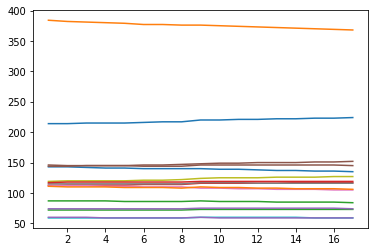

In [294]:
data_reshaped = df_sel_null_col['v'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.show()

In [295]:
def lq_lin(x, a, b):
    return x*a + b 

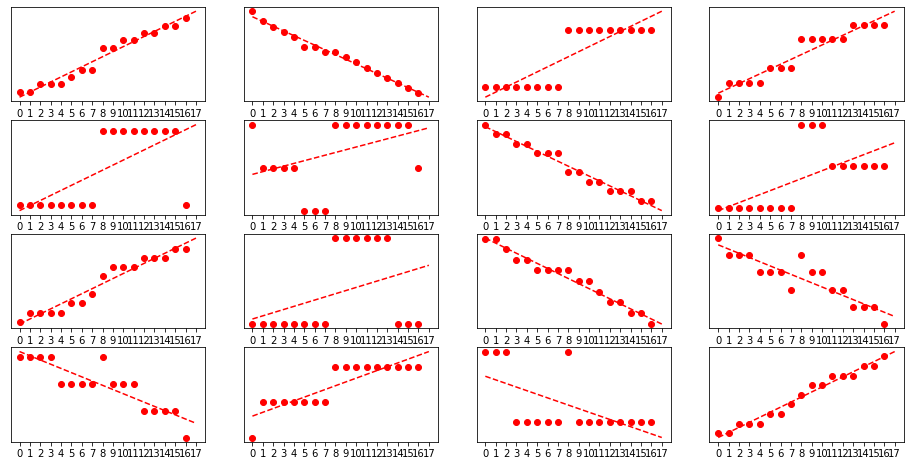

In [298]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq_lin, x, data_reshaped[1:,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq_lin(xmodel, a, b)
    
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[1:,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
    plt.xticks(range(18))
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.show()

In [299]:
for w in range(data_reshaped.shape[1]):
    stat_list_org[0]['ludnosc_na_1km2'][w] = data_reshaped[1,w]
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.show()

<ipython-input-299-9441af5298d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['ludnosc_na_1km2'][w] = data_reshaped[1,w]


### udzial_wiek_produkcyjny

In [301]:
def lq(x, a, b, c):
    return x*x*a + x*b + c

x = np.arange(17)

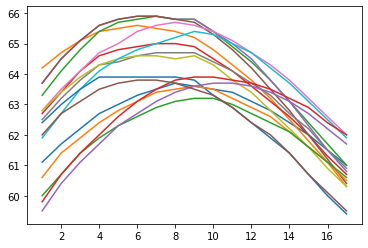

In [302]:
data_reshaped = df_sel_null_col['udzial_wiek_produkcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.show()

In [303]:
data_reshaped.shape

(18, 16)

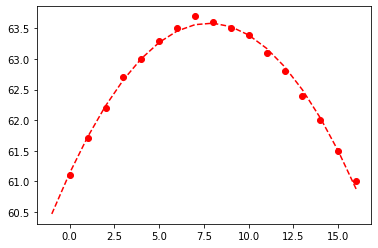

In [304]:
(a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,0], p0=[0.05,0.05,0.05])
xmodel = np.arange(-1,17)
ymodel = lq(xmodel, a, b, c)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[1:,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
plt.show()

In [305]:
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]

<ipython-input-305-64f0fcb14bea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]


### udzial_wiek_przedprodukcyjny

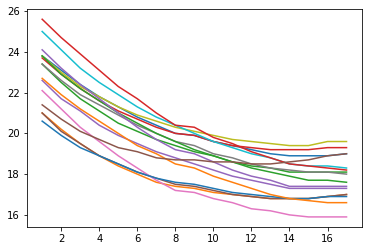

In [306]:
data_reshaped = df_sel_null_col['udzial_wiek_przedprodukcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.show()

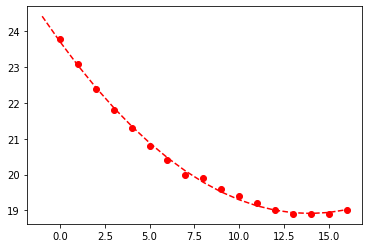

In [307]:
(a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,0], p0=[0.05,0.05,0.05])
xmodel = np.arange(-1,17)
ymodel = lq(xmodel, a, b, c)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[1:,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
plt.show()

In [308]:
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]

<ipython-input-308-b587ef9f47ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]


### udzial_wiek_poprodukcyjny

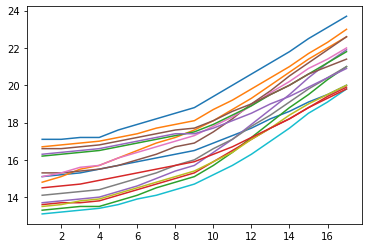

In [309]:
data_reshaped = df_sel_null_col['udzial_wiek_poprodukcyjny'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.show()

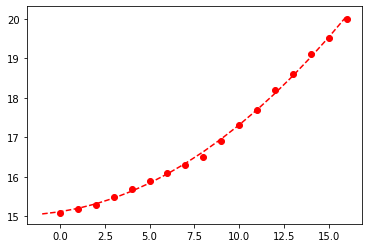

In [310]:
(a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,0], p0=[0.05,0.05,0.05])
xmodel = np.arange(-1,17)
ymodel = lq(xmodel, a, b, c)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[1:,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
plt.show()

In [311]:
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]

<ipython-input-311-22b7f9e1296c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]


### przestepstwa_ogolem

In [312]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

In [313]:
def lq_sin(x, a, b, c, d):
    return np.sin(x/a*np.pi)*b + x*c + d

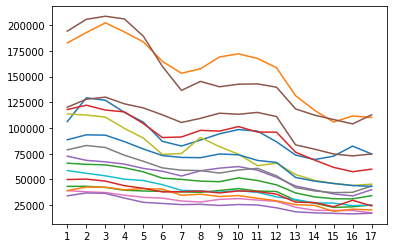

In [314]:
data_reshaped = df_sel_null_col['przestepstwa_ogolem'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.xticks(range(1,18))
plt.show()

#### MINMAX rescaling

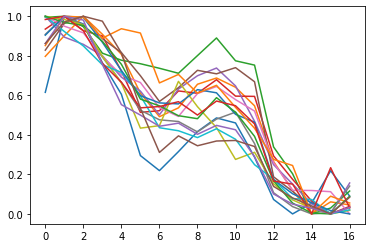

In [315]:
minmax_data_reshaped = preprocessing.minmax_scale(data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1))
plt.plot(minmax_data_reshaped)
plt.show()

#### Comparing each year with best line

In [316]:
notnull_data_reshaped = data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1)

In [317]:
mx = notnull_data_reshaped.max(0)
mn = notnull_data_reshaped.min(0)

<ipython-input-318-c1f598295c77>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['przestepstwa_ogolem'][w] = ymodel[0]*(mx[w]-mn[w])+mn[w]
<ipython-input-318-c1f598295c77>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['przestepstwa_ogolem'][w] = ymodel[0]*(mx[w]-mn[w])+mn[w]
<ipython-input-318-c1f598295c77>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[0]['przestepstwa_ogolem'][

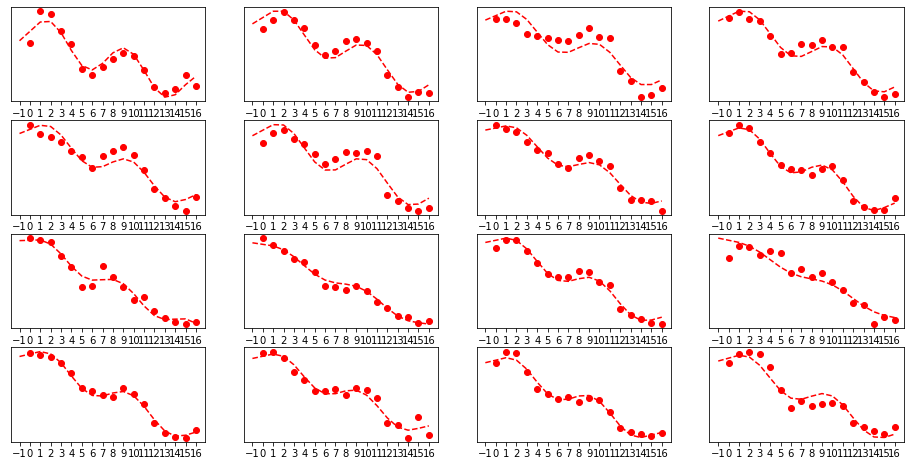

In [318]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq_sin, 
                                x, 
                                minmax_data_reshaped[:,w], # data_reshaped[1:,w], 
                                p0=[4,6,-1,1], maxfev = 100000)
    xmodel = np.arange(-1,17)
    ymodel = lq_sin(xmodel, a,b,c,d)
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, 
             minmax_data_reshaped[:,w],#data_reshaped[1:,w], 
             "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
    plt.xticks(range(-1,17))
    stat_list_org[0]['przestepstwa_ogolem'][w] = ymodel[0]*(mx[w]-mn[w])+mn[w]
plt.show()

### dochody_brutto_na_mieszkanca

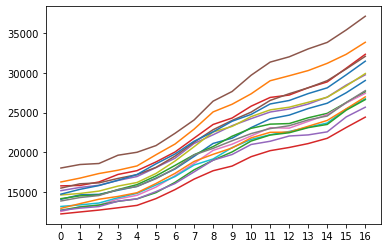

In [319]:
data_reshaped = df_sel_null_col['dochody_brutto_na_mieszkanca'].values.reshape(18,-1)
plt.plot(data_reshaped)
plt.xticks(range(17))
plt.show()

In [320]:
def lq3(x, a, b, c, d):
    return x*x*x*a + x*x*b + x*c + d

x = np.arange(17)

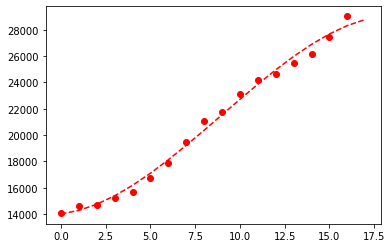

In [321]:
(a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,0], p0=[1,1,1,1])
xmodel = np.arange(18)
ymodel = lq3(xmodel, a, b, c,d)
fig, ax1 = plt.subplots()
ax1.plot(x, data_reshaped[:-1,0], "ro", label="Experiment")
ax1.plot(xmodel,ymodel, "r--", label="Model")
plt.show()

<ipython-input-322-3680c0c2a125>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
<ipython-input-322-3680c0c2a125>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
<ipython-input-322-3680c0c2a125>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymo

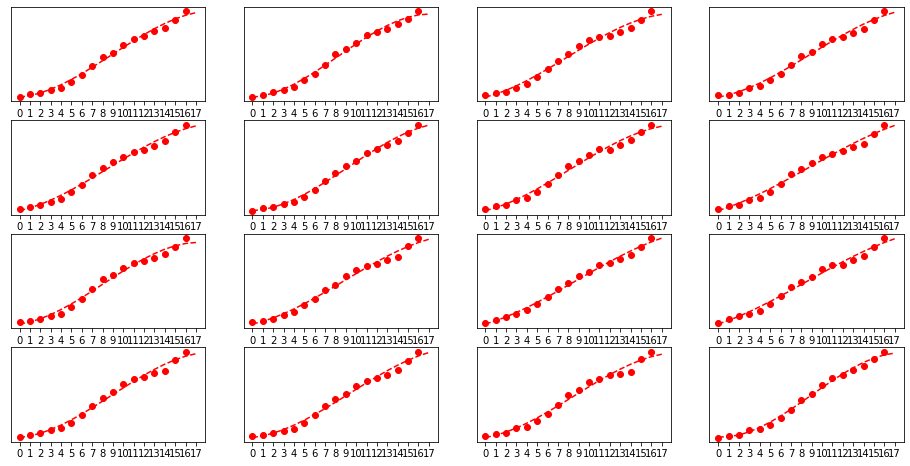

In [322]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,w], p0=[1,1,1,1])
    xmodel = np.arange(18)
    ymodel = lq3(xmodel, a, b, c,d)
    
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[:-1,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
    plt.xticks(range(18))
    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.show()

## Creating new stat data

In [325]:
stat_list_org[0].max(0)

emeryci_i_rencisci                  1.169706e+06
bezrobocie_zarejsestrowane          3.461180e+05
bezrobocie_zarejsestrowane_gminy             NaN
malzenstwa_zawarte                  2.619400e+04
ludnosc_na_1km2                     3.840000e+02
dochody_gminy                       9.939423e+09
dochody_na_mieszkanca                        NaN
wyksztalcenie_wyzsze                3.200000e+00
wyksztalcenie_gim_pod_nizsze        3.290000e+01
wyksztalcenie_srednie               3.380000e+01
rozwody_powiat                      6.661000e+03
udzial_wiek_przedprodukcyjny        2.646029e+01
udzial_wiek_produkcyjny             6.383676e+01
udzial_wiek_poprodukcyjny           1.693382e+01
praca_najemna                       3.956700e+02
praca_wlasny_rachunek               8.107000e+01
socjal_500plus                               NaN
socjal                              2.537100e+02
dochody_brutto_na_mieszkanca        1.800900e+04
PKB_na_1_mieszkanca                 3.132500e+04
przestepstwa_ogolem 

In [326]:
for s in stat_list_org:
    s['ludnosc'] = s['ludnosc_na_1km2']*s['powierzchnnia_km2']
    s['przestepstwa_ludnosc'] = s['przestepstwa_ogolem']/s['ludnosc']
    s['emeryci_i_rencisci_ludnosc'] = s['emeryci_i_rencisci']/s['ludnosc']
    s['bezrobocie_zarejsestrowane_ludnosc'] = s['bezrobocie_zarejsestrowane']/s['ludnosc']
    s['malzenstwa_zawarte_ludnosc'] = s['malzenstwa_zawarte']/s['ludnosc']
    s['dochody_gminy_ludnosc'] = s['dochody_gminy']/s['ludnosc']
    s['rozwody_powiat_ludnosc'] = s['rozwody_powiat']/s['ludnosc']
    s['rozwody_malzenstwa'] = s['rozwody_powiat']/s['malzenstwa_zawarte']

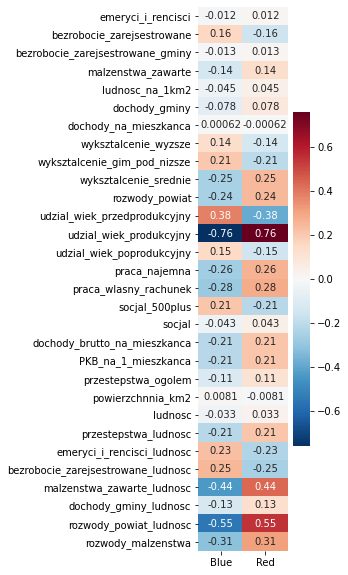

In [327]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

## Rescale the data

In [328]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [329]:
stat_list_minmax = stat_list_org.copy()
stat_list_mean = stat_list_org.copy()

In [330]:
#MINMAX scaling
for st in range(len(stat_list_org)):
    stat_list_minmax[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # min max normalization
    stat_list_minmax[st] = (stat_list_minmax[st]-stat_list_minmax[st].min(0)) / (stat_list_minmax[st].max(0)-stat_list_minmax[st].min(0))

In [331]:
for st in range(len(stat_list_org)):
    stat_list_mean[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # nrmalization mean (around 0)
    stat_list_mean[st] = (stat_list_mean[st]-stat_list_mean[st].mean(0)) / (stat_list_mean[st].std(0))

In [332]:
stat_list = stat_list_mean if (True) else stat_list_minmax

## Examining stat data

In [333]:
len(stat_list)

18

In [334]:
len(stat_list_org)

18

In [335]:
len(pool_d[:-1])

18

In [336]:
pool_stat_m = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_mean, pool_d[1:])]
pool_stat_mm = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_minmax, pool_d[1:])]

In [337]:
pool_stat_df_m = pd.concat(pool_stat_m).reset_index(drop=True)
pool_stat_df_mm = pd.concat(pool_stat_mm).reset_index(drop=True)

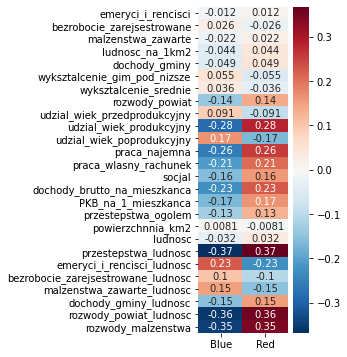

In [338]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

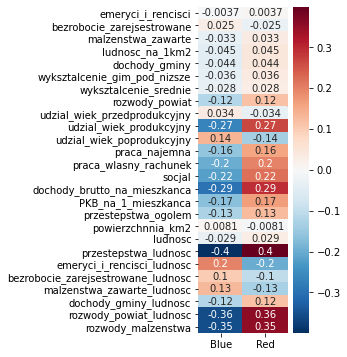

In [339]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [348]:
potential_cols = pool_stat_df_m.corr().iloc[:-2,-1].abs()
potential_cols = potential_cols[potential_cols>0.1]
high_cols = potential_cols.index.values.tolist()

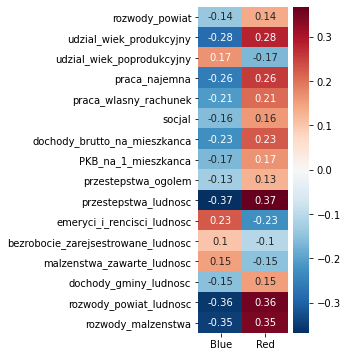

In [350]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().loc[high_cols,['Blue','Red']], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

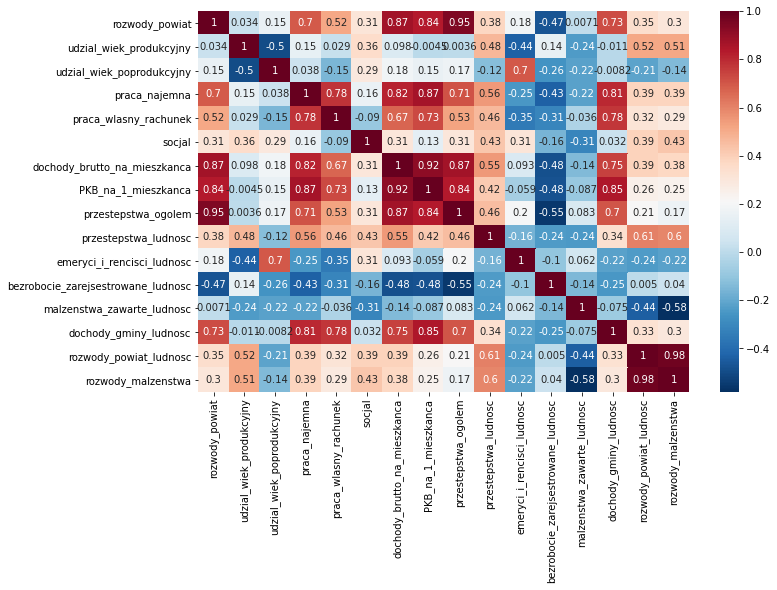

In [353]:
fig, ax = plt.subplots(figsize=(11,7))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.show()

In [354]:
stat_list = [st.loc[:,high_cols] for st in stat_list]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [338]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [339]:
X = np.array(X)
X.shape

(18, 16, 7)

## Prepare Y

In [340]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [341]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [342]:
X.shape

(18, 16, 7)

### Models with percentage of Blue support per district

In [343]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x)
    return y1

### Setup for testing model

In [344]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [349]:
st_data.shape

(16, 5)

In [350]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+2))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [351]:
def model(a,x,Y,st_list):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [352]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 7)

## Use output -> next input (grad each step)

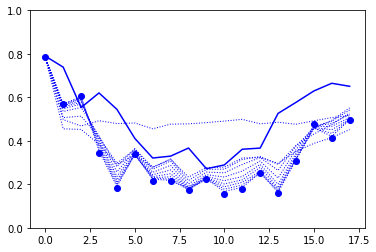

In [378]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


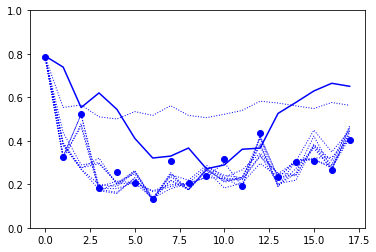

In [379]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


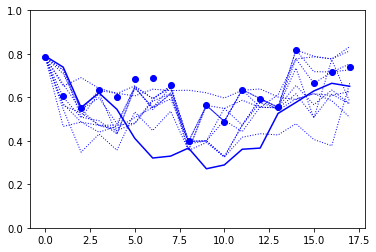

In [380]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 10

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

[]

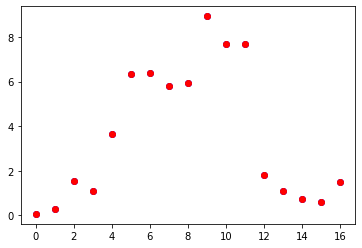

In [264]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [56]:
(a_avg-a_all).max()

0.004963590920596506